# MAT 328 - Final Project
### Tony Lu

---

This project uses the [Motor Vehicle Collision](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) dataset offered by [NYC Open Data](http://opendata.cityofnewyork.us/).

All data and values are dated March 2021 - the most recent date this notebook was executed. Executing this notebook at a later date may yield different results compared to what is already rendered in this notebook.

# Project Setup

### Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.tree import plot_tree

%matplotlib inline
sns.set_theme(style='darkgrid')

### Download and load the data

In [2]:
# This might take awhile. It has 1.7 million rows after all.
raw_data = pd.read_csv('https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,22,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = raw_data.copy()

### Show the data

In [4]:
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,08/23/2020,14:25,QUEENS,11434,40.672382,-73.78574,"(40.672382, -73.78574)",ROCKAWAY BOULEVARD,BAISLEY BOULEVARD,NaN,1.0,0.0,0,0,0,0,1,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4341417,Sedan,Sedan,NaN,NaN,NaN
1,09/30/2020,13:35,NaN,NaN,40.584250,-73.96380,"(40.58425, -73.9638)",BELT PARKWAY,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Other Vehicular,NaN,NaN,NaN,NaN,4353423,Sedan,NaN,NaN,NaN,NaN
2,09/10/2020,22:07,NaN,NaN,40.790417,-73.95184,"(40.790417, -73.95184)",EAST 101 STREET,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4347736,Sedan,NaN,NaN,NaN,NaN
3,10/05/2020,16:42,BRONX,10460,40.838390,-73.88606,"(40.83839, -73.88606)",BOSTON ROAD,HOE AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,NaN,NaN,4355042,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,08/24/2020,16:08,BRONX,10466,40.899517,-73.84716,"(40.899517, -73.84716)",NaN,NaN,4413 EDSON AVENUE,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4342909,Sedan,NaN,NaN,NaN,NaN


In [5]:
# Show size of the data
print(f'Rows: {df.shape[0]} | Columns: {df.shape[1]}')

Rows: 1769702 | Columns: 29


In [6]:
df.describe(include='all')

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
count,1769702,1769702,1225740,1225528.0,1.560337e+06,1.560337e+06,1560337,1412598,1146027,264736,1.769684e+06,1.769671e+06,1.769702e+06,1.769702e+06,1.769702e+06,1.769702e+06,1.769702e+06,1.769702e+06,1764715,1518624,118838,25618,6706,1.769702e+06,1760347,1475806,115583,24902,6530
unique,3205,1440,5,431.0,NaN,NaN,229264,12115,18901,161790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,61,50,39,29,NaN,1219,1313,186,76,54
top,01/21/2014,16:00,BROOKLYN,11207.0,NaN,NaN,"(0.0, 0.0)",BROADWAY,3 AVENUE,772 EDGEWATER ROAD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,NaN,Sedan,Sedan,Sedan,Sedan,Sedan
freq,1161,25551,384373,15085.0,NaN,NaN,1766,17269,9843,402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,632901,1276959,110593,24157,6315,NaN,434189,319640,31040,7179,1942
mean,NaN,NaN,NaN,NaN,4.067809e+01,-7.384509e+01,NaN,NaN,NaN,NaN,2.736144e-01,1.260121e-03,5.153184e-02,6.633885e-04,2.291911e-02,9.493124e-05,1.989996e-01,5.006493e-04,NaN,NaN,NaN,NaN,NaN,2.917858e+06,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.371572e+00,2.703046e+00,NaN,NaN,NaN,NaN,6.687317e-01,3.753458e-02,2.335054e-01,2.629072e-02,1.513429e-01,9.800633e-03,6.305173e-01,2.446877e-02,NaN,NaN,NaN,NaN,NaN,1.502896e+06,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000e+00,-2.013600e+02,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,2.200000e+01,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.066854e+01,-7.397596e+01,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,2.879737e+06,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,4.072210e+01,-7.392835e+01,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,3.521010e+06,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,4.076888e+01,-7.386663e+01,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,3.963676e+06,NaN,NaN,NaN,NaN,NaN


### Data Handling
- Clean up unneeded data
- Make sure the correct dtypes are being used
- Handle missing data

#### Unneeded data

In [7]:
# We don't need COLLISION_ID as its more of a unique identifier for internal use
# LOCATION is just a combination of LONGITUDE and LATITUDE, having either is fine
df.drop(['COLLISION_ID', 'LOCATION'], axis=1, inplace=True)

#### Check and handle missing values

In [8]:
# Check which columns have missing values
nulls = df.isnull().sum()
nulls[nulls > 0]

BOROUGH                           543962
ZIP CODE                          544174
LATITUDE                          209365
LONGITUDE                         209365
ON STREET NAME                    357104
CROSS STREET NAME                 623675
OFF STREET NAME                  1504966
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
CONTRIBUTING FACTOR VEHICLE 1       4987
CONTRIBUTING FACTOR VEHICLE 2     251078
CONTRIBUTING FACTOR VEHICLE 3    1650864
CONTRIBUTING FACTOR VEHICLE 4    1744084
CONTRIBUTING FACTOR VEHICLE 5    1762996
VEHICLE TYPE CODE 1                 9355
VEHICLE TYPE CODE 2               293896
VEHICLE TYPE CODE 3              1654119
VEHICLE TYPE CODE 4              1744800
VEHICLE TYPE CODE 5              1763172
dtype: int64

`CONTRIBUTING FACTOR VEHICLE` and `VEHICLE TYPE CODE` are used to identify the vehicle involved in the collision as well as the vehicle's role in the collision. 

`CONTRIBUTING FACTOR VEHICLE` and `VEHICLE TYPE CODE` can be kept as null. For a particular collision with 2 vehicles, The data should include information for these two vehicles but vehicles 3, 4, and 5 should be empty - it would make sense that values are missing from these columns.

In [9]:
# Drop missing values
# OFF STREET NAME has too many missing values for us to take care of.
# With over 1.4 million missing values, it's over 80% of the data.
df.drop('OFF STREET NAME', axis=1, inplace=True)

# The data serves us no purpose if the geo-coordinates are missing.
# The coords can be used to retrieve info about borough, street, ZIP code
df.dropna(how='any', subset=['LATITUDE', 'LONGITUDE'], inplace=True)

In [10]:
# Impute missing values

# For "NUMBER OF PERSONS INJURED" and "NUMBER OF PERSONS KILLED",
# There is only a small amount of values missing which makes it easy for us to impute it

# Impute "NUMBER OF PERSONS INJURED" via mean
injured_mean = df['NUMBER OF PERSONS INJURED'].mean()
df['NUMBER OF PERSONS INJURED'].replace(np.nan, injured_mean, inplace=True)

# Impute "NUMBER OF PERSONS KILLED" via mean
killed_mean = df['NUMBER OF PERSONS KILLED'].mean()
df['NUMBER OF PERSONS KILLED'].replace(np.nan, killed_mean, inplace=True)

The next few columns to worry about are `ZIP CODE`, `BOROUGH`, and `ON STREET NAME`. If we check the number of records with values missing in any of the 3 columns, we will see that there is about 600,000 values missing in total. Or about 35% of the total data - which is a big chunk of the total data but not enough to leave a huge impact if we drop them. By dropping them, we'll still have about 1 million left.

In [11]:
filter = df[['ZIP CODE', 'BOROUGH', 'ON STREET NAME']].isnull().any(1)
df[filter].shape

(595061, 26)

In [12]:
df.dropna(how='any', subset=['ZIP CODE', 'BOROUGH', 'ON STREET NAME'], inplace=True)
df.shape

(965276, 26)

#### Check dtypes

In [13]:
df.dtypes

CRASH DATE                        object
CRASH TIME                        object
BOROUGH                           object
ZIP CODE                          object
LATITUDE                         float64
LONGITUDE                        float64
ON STREET NAME                    object
CROSS STREET NAME                 object
NUMBER OF PERSONS INJURED        float64
NUMBER OF PERSONS KILLED         float64
NUMBER OF PEDESTRIANS INJURED      int64
NUMBER OF PEDESTRIANS KILLED       int64
NUMBER OF CYCLIST INJURED          int64
NUMBER OF CYCLIST KILLED           int64
NUMBER OF MOTORIST INJURED         int64
NUMBER OF MOTORIST KILLED          int64
CONTRIBUTING FACTOR VEHICLE 1     object
CONTRIBUTING FACTOR VEHICLE 2     object
CONTRIBUTING FACTOR VEHICLE 3     object
CONTRIBUTING FACTOR VEHICLE 4     object
CONTRIBUTING FACTOR VEHICLE 5     object
VEHICLE TYPE CODE 1               object
VEHICLE TYPE CODE 2               object
VEHICLE TYPE CODE 3               object
VEHICLE TYPE COD

In [14]:
# Fix the dtypes

df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])

# These should be ints, not floats - can't have half a person dead
df['NUMBER OF PERSONS INJURED'] = df['NUMBER OF PERSONS INJURED'].astype(int)
df['NUMBER OF PERSONS KILLED'] = df['NUMBER OF PERSONS KILLED'].astype(int)

#### Miscellaneous Cleanup

In [15]:
# Convert everything to uppercase to be consistent
# This might take a few seconds or minutes depending on system
# Took about ~10 seconds via Google Colab
df = df.applymap(lambda s:s.upper() if type(s) == str else s)
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2020-08-23,2021-04-13 14:25:00,QUEENS,11434,40.672382,-73.785740,ROCKAWAY BOULEVARD,BAISLEY BOULEVARD,1,0,0,0,0,0,1,0,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,NaN,NaN,NaN,SEDAN,SEDAN,NaN,NaN,NaN
3,2020-10-05,2021-04-13 16:42:00,BRONX,10460,40.838390,-73.886060,BOSTON ROAD,HOE AVENUE,0,0,0,0,0,0,0,0,DRIVER INATTENTION/DISTRACTION,DRIVER INATTENTION/DISTRACTION,NaN,NaN,NaN,SEDAN,STATION WAGON/SPORT UTILITY VEHICLE,NaN,NaN,NaN
7,2020-09-03,2021-04-13 16:45:00,QUEENS,11364,40.745540,-73.776800,FRANCIS LEWIS BOULEVARD,58 AVENUE,1,0,0,0,0,0,1,0,FOLLOWING TOO CLOSELY,UNSPECIFIED,NaN,NaN,NaN,STATION WAGON/SPORT UTILITY VEHICLE,SEDAN,NaN,NaN,NaN
10,2020-09-19,2021-04-13 21:09:00,QUEENS,11368,40.751545,-73.870850,JUNCTION BOULEVARD,37 AVENUE,0,0,0,0,0,0,0,0,PASSING OR LANE USAGE IMPROPER,UNSPECIFIED,NaN,NaN,NaN,STATION WAGON/SPORT UTILITY VEHICLE,SEDAN,NaN,NaN,NaN
12,2020-09-19,2021-04-13 14:30:00,BRONX,10462,40.854504,-73.867714,WHITE PLAINS ROAD,LYDIG AVENUE,1,0,1,0,0,0,0,0,UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Explore the Data

Now that our data is formatted and a bit cleaned up, let's see what it can tell us.

Here we have a few questions the data might help answer:
- When and where do collisions occur?
- Who's involved?
- What's the most common reason behind a collision?
- Could a particular vehicle be the cause of most collisions?
- Are there hotspots that may cause more collisions/deaths?

## Single Variable Plots

#### Collisions by Region

With Manhattan being such a hotspot for NYC residents and tourists, one might believe Manhattan would have the most collisions. But in the following chart, we can see that isn't true. Brooklyn leads the all-time collision count at about 300,000 and Queens follows closely at a little over 250,000.

Text(0, 0.5, 'Total Collisions')

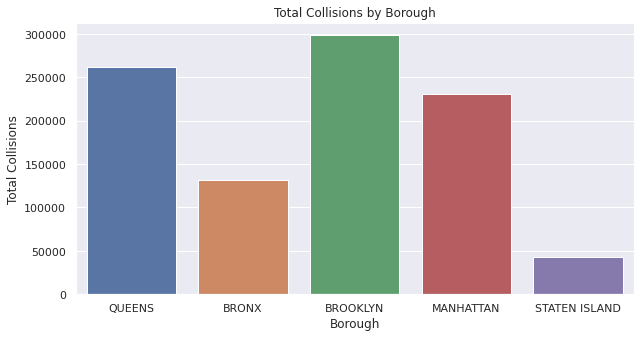

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(data=df, x='BOROUGH')
plt.title('Total Collisions by Borough')
plt.xlabel('Borough')
plt.ylabel('Total Collisions')

#### Collisions Over Time

Another good metric to explore is time. In the following graph, we can see the total collision reports per month, spanning from the data's inception of 2012.

Now that we're looking at the monthly collisions, we'll notice that all the years collectively have a relatively low amount of collision reports in the first half of the year, especially the month of April. However, interestingly, as the summer begins to approach, the number of collisions start to drastically increase and plateau until the year ends.

Text(0, 0.5, 'Total Collisions')

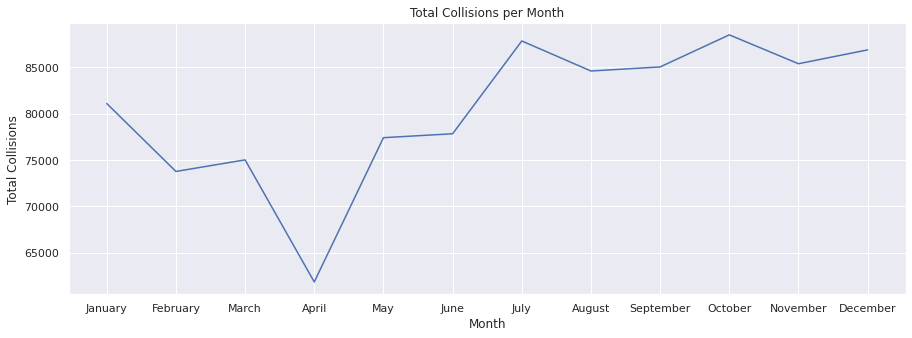

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))

# Extract the month from all collisions
df_monthly = df['CRASH DATE'].dt.month_name().value_counts().to_frame('total')

# Re-order the rows by month
months_inorder = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_monthly = df_monthly.reindex(months_inorder, axis=0)

# Display it
sns.lineplot(data=df_monthly, x=df_monthly.index, y='total')
plt.title('Total Collisions per Month')
plt.xlabel('Month')
plt.ylabel('Total Collisions')

#### Persons Involved

Paying attention to the road is likely the most important aspect to master for anyone piloting a vehicle as lack of experience here can cause fatal consequences - like the victims reported in these collisions. But that skill doesn't apply only to the drivers but the pedestrians as well.

In the following, we will be looking at the people involved during collisions. How many are injured? How many suffered a lethal consequence?

Text(0, 0.5, 'Count')

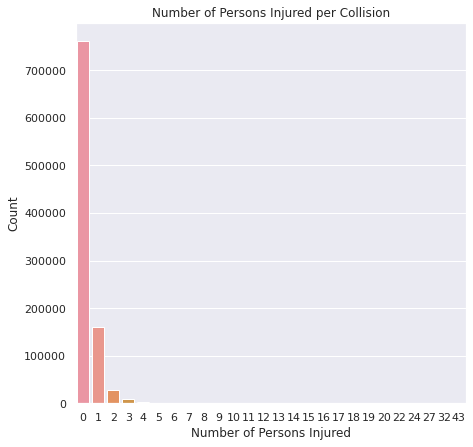

In [18]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.countplot(data=df, x='NUMBER OF PERSONS INJURED')
plt.title('Number of Persons Injured per Collision')
plt.xlabel('Number of Persons Injured')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

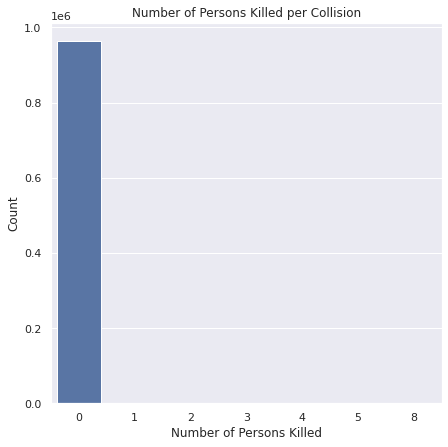

In [19]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.countplot(data=df, x='NUMBER OF PERSONS KILLED')

plt.title('Number of Persons Killed per Collision')
plt.xlabel('Number of Persons Killed')
plt.ylabel('Count')

The above plots give us information on how many people are involved in the collisions and whether or not they suffered injuries and/or deaths. As it's noticeable, both plots have a large bar at zero which thankfully means a large portion of collisions involve no one being injured or dead. However, that doesn't mean it doesn't happen. In the plot representing individuals who were injured, we can see a couple hundred-thousand instances where one or more people are injured. As for the plot representing individuals who suffered fatality, the bars are not even visible due to "zero" being so large, almost reaching one million instances.

## Multivariable Plots

Now let's look at the relationships between multiple variables.

Text(0, 0.5, 'Number of Collisions')

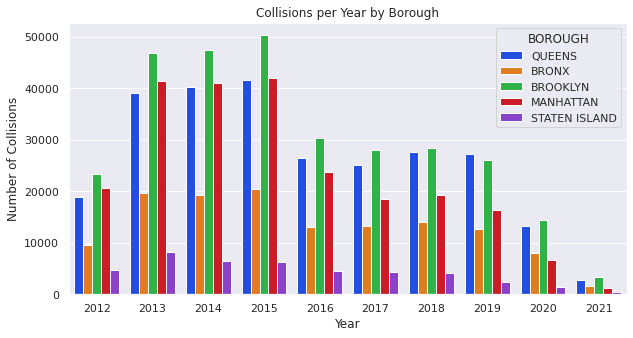

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(data=df, x=df['CRASH DATE'].dt.year, hue='BOROUGH', palette='bright')
plt.title('Collisions per Year by Borough')
plt.xlabel('Year')
plt.ylabel('Number of Collisions')

The figure above shows the number of collision reports per year in each borough. If we look at this closely, we’ll notice that each borough had a drastic increase in collisions starting from 2012 up until 2015. After that year, each borough began its overall decline in collisions. The decrease in collisions after 2015 might even be at the credit of the city government’s Vision Zero Campaign - a citywide initiative aimed to protect the public and reduce traffic accidents. 

Text(0, 0.5, 'Total Collisions')

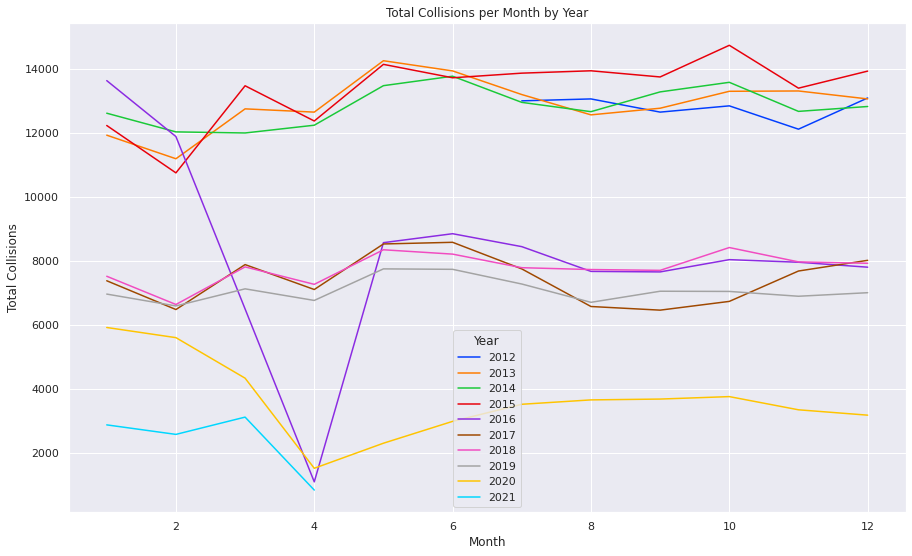

In [21]:
month_year = pd.DataFrame()
month_year['CRASH YEAR'] = df['CRASH DATE'].dt.year
month_year['CRASH MONTH'] = df['CRASH DATE'].dt.month
month_year = month_year.value_counts().to_frame('TOTAL COLLISIONS').sort_index(ascending=True)

fig, ax = plt.subplots(figsize=(15, 9))
sns.lineplot(data=month_year, x='CRASH MONTH', y='TOTAL COLLISIONS', hue='CRASH YEAR', palette='bright')
plt.title('Total Collisions per Month by Year')
plt.legend(title='Year')
plt.xlabel('Month')
plt.ylabel('Total Collisions')

We found out earlier that Brooklyn was the leader amongst the 5 boroughs for the most collisions, let's take a look into that. In the following figure, we can see the top ten streets in Brooklyn with collisions. According to that plot, it seems Atlantic Ave, Flatbush Ave and Linden Boulevard are the most accident-prone areas of Brooklyn, with about 21,000 collisions since 2012 - that's roughly 2,600 collisions per year. Maybe it's a good idea to travel with caution the next time you enter these areas.

Sum of Top 3 Streets: 21061


Text(0, 0.5, 'Street Name')

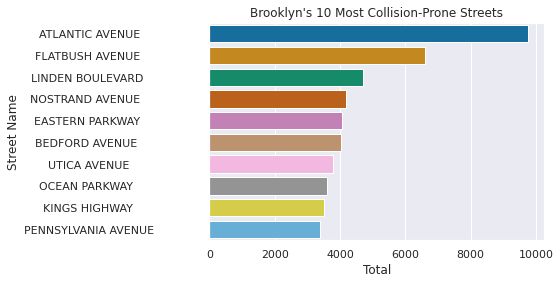

In [22]:
brooklyndf = df[df['BOROUGH'] == 'BROOKLYN']

brooklyndf = brooklyndf['ON STREET NAME'].value_counts()[:10].to_frame('total').reset_index()
brooklyndf.rename(columns={'index': 'street'}, inplace=True)

print(f"Sum of Top 3 Streets: {brooklyndf['total'].loc[:2].sum()}")

sns.barplot(x='total', y='street', data=brooklyndf, palette='colorblind')
plt.title('Brooklyn\'s 10 Most Collision-Prone Streets')
plt.xlabel('Total')
plt.ylabel('Street Name')

If we look at the yearly collisions and how people are affected, the dataset shows injuries due to collisions have luckily decreased overall.

Text(0, 0.5, 'Number of Injured')

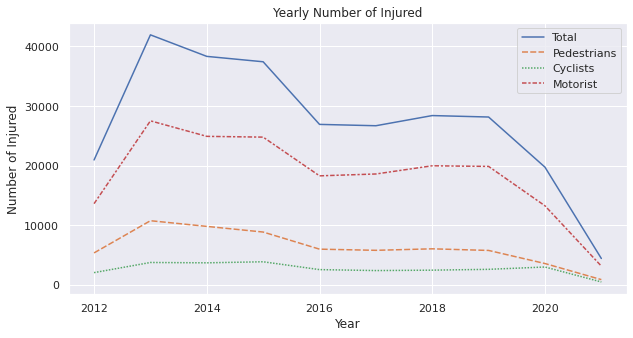

In [23]:
injured_cols = ['CRASH DATE', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
yearly_injured_df = df[injured_cols]
yearly_injured_df = yearly_injured_df.groupby(yearly_injured_df['CRASH DATE'].dt.year).sum()

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=yearly_injured_df)
plt.legend(['Total', 'Pedestrians', 'Cyclists', 'Motorist'])
plt.title('Yearly Number of Injured')
plt.xlabel('Year')
plt.ylabel('Number of Injured')

# Prediction Models

## Predicting the Number of Injured via K-Nearest Neighbor

Given our previous graphs, charts and values, we can see that there are many collisions throughout a year. It's hard to prevent these sorts of accidents as we don't control the lives of these people. The best we can do is initiate awareness programs and advertise around the city to remind drivers, cyclists, or whoever, to stay safe - like the Vision Zero Campaign mentioned earlier.

However, with the help of data science models such as linear regression, polynomial regression, and other classifications, we can use the data we have to predict future accidents - or least in this case, predict what we can expect from future accidents.

Unfortunately, emergency services are limited. Therefore the distribution of aid must be overseen and managed efficiently. Managing these services can become easier if we know what to expect from an incident. In this example, we will be using the K-Nearest Neighbor model to predict the number of injured individuals in any given collision report. That way, when responding to an emergency, we aren't sending ten ambulances for a small collision involving two cyclists. 

In [24]:
# Remove all the columns we don't need
prediction_df = df.drop(columns=['CRASH DATE', 'CRASH TIME', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'CROSS STREET NAME', 'ON STREET NAME', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',	'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',	'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'])
prediction_df.head()

,BOROUGH,NUMBER OF PERSONS INJURED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,QUEENS,1,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,NaN,NaN,NaN,SEDAN,SEDAN,NaN,NaN,NaN
3,BRONX,0,DRIVER INATTENTION/DISTRACTION,DRIVER INATTENTION/DISTRACTION,NaN,NaN,NaN,SEDAN,STATION WAGON/SPORT UTILITY VEHICLE,NaN,NaN,NaN
7,QUEENS,1,FOLLOWING TOO CLOSELY,UNSPECIFIED,NaN,NaN,NaN,STATION WAGON/SPORT UTILITY VEHICLE,SEDAN,NaN,NaN,NaN
10,QUEENS,0,PASSING OR LANE USAGE IMPROPER,UNSPECIFIED,NaN,NaN,NaN,STATION WAGON/SPORT UTILITY VEHICLE,SEDAN,NaN,NaN,NaN
12,BRONX,1,UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Create dummy variables from our categorical columns
prediction2 = pd.get_dummies(prediction_df, columns=['BOROUGH', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'], drop_first=True)
prediction2.head()

,NUMBER OF PERSONS INJURED,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN ISLAND,CONTRIBUTING FACTOR VEHICLE 1_ACCELERATOR DEFECTIVE,CONTRIBUTING FACTOR VEHICLE 1_AGGRESSIVE DRIVING/ROAD RAGE,CONTRIBUTING FACTOR VEHICLE 1_ALCOHOL INVOLVEMENT,CONTRIBUTING FACTOR VEHICLE 1_ANIMALS ACTION,CONTRIBUTING FACTOR VEHICLE 1_BACKING UNSAFELY,CONTRIBUTING FACTOR VEHICLE 1_BRAKES DEFECTIVE,CONTRIBUTING FACTOR VEHICLE 1_CELL PHONE (HAND-HELD),CONTRIBUTING FACTOR VEHICLE 1_CELL PHONE (HANDS-FREE),CONTRIBUTING FACTOR VEHICLE 1_DRIVER INATTENTION/DISTRACTION,CONTRIBUTING FACTOR VEHICLE 1_DRIVER INEXPERIENCE,CONTRIBUTING FACTOR VEHICLE 1_DRIVERLESS/RUNAWAY VEHICLE,CONTRIBUTING FACTOR VEHICLE 1_DRUGS (ILLEGAL),CONTRIBUTING FACTOR VEHICLE 1_EATING OR DRINKING,CONTRIBUTING FACTOR VEHICLE 1_FAILURE TO KEEP RIGHT,CONTRIBUTING FACTOR VEHICLE 1_FAILURE TO YIELD RIGHT-OF-WAY,CONTRIBUTING FACTOR VEHICLE 1_FATIGUED/DROWSY,CONTRIBUTING FACTOR VEHICLE 1_FELL ASLEEP,CONTRIBUTING FACTOR VEHICLE 1_FOLLOWING TOO CLOSELY,CONTRIBUTING FACTOR VEHICLE 1_GLARE,CONTRIBUTING FACTOR VEHICLE 1_HEADLIGHTS DEFECTIVE,CONTRIBUTING FACTOR VEHICLE 1_ILLNES,CONTRIBUTING FACTOR VEHICLE 1_ILLNESS,CONTRIBUTING FACTOR VEHICLE 1_LANE MARKING IMPROPER/INADEQUATE,CONTRIBUTING FACTOR VEHICLE 1_LISTENING/USING HEADPHONES,CONTRIBUTING FACTOR VEHICLE 1_LOST CONSCIOUSNESS,CONTRIBUTING FACTOR VEHICLE 1_OBSTRUCTION/DEBRIS,CONTRIBUTING FACTOR VEHICLE 1_OTHER ELECTRONIC DEVICE,CONTRIBUTING FACTOR VEHICLE 1_OTHER LIGHTING DEFECTS,CONTRIBUTING FACTOR VEHICLE 1_OTHER VEHICULAR,CONTRIBUTING FACTOR VEHICLE 1_OUTSIDE CAR DISTRACTION,CONTRIBUTING FACTOR VEHICLE 1_OVERSIZED VEHICLE,CONTRIBUTING FACTOR VEHICLE 1_PASSENGER DISTRACTION,CONTRIBUTING FACTOR VEHICLE 1_PASSING OR LANE USAGE IMPROPER,CONTRIBUTING FACTOR VEHICLE 1_PASSING TOO CLOSELY,CONTRIBUTING FACTOR VEHICLE 1_PAVEMENT DEFECTIVE,...,VEHICLE TYPE CODE 4_TOYOT,VEHICLE TYPE CODE 4_TRACTOR TRUCK DIESEL,VEHICLE TYPE CODE 4_TRACTOR TRUCK GASOLINE,VEHICLE TYPE CODE 4_TRAILOR,VEHICLE TYPE CODE 4_UNKNOWN,VEHICLE TYPE CODE 4_VAN,VEHICLE TYPE CODE 5_4 DR SEDAN,VEHICLE TYPE CODE 5_AMBULANCE,VEHICLE TYPE CODE 5_BACK,VEHICLE TYPE CODE 5_BICYCLE,VEHICLE TYPE CODE 5_BIKE,VEHICLE TYPE CODE 5_BOX TRUCK,VEHICLE TYPE CODE 5_BUS,VEHICLE TYPE CODE 5_CARRY ALL,VEHICLE TYPE CODE 5_CHASSIS CAB,VEHICLE TYPE CODE 5_CONVERTIBLE,VEHICLE TYPE CODE 5_DUMP,VEHICLE TYPE CODE 5_E-SCOOTER,VEHICLE TYPE CODE 5_FRONT,VEHICLE TYPE CODE 5_LARGE COM VEH(6 OR MORE TIRES),VEHICLE TYPE CODE 5_LIVERY VEHICLE,VEHICLE TYPE CODE 5_MOTORCYCLE,VEHICLE TYPE CODE 5_MOTORSCOOTER,VEHICLE TYPE CODE 5_OTHER,VEHICLE TYPE CODE 5_PASSENGER VEHICLE,VEHICLE TYPE CODE 5_PICK-UP TRUCK,VEHICLE TYPE CODE 5_PK,VEHICLE TYPE CODE 5_SCOOTER,VEHICLE TYPE CODE 5_SEDAN,VEHICLE TYPE CODE 5_SMALL COM VEH(4 TIRES),VEHICLE TYPE CODE 5_SPORT UTILITY / STATION WAGON,VEHICLE TYPE CODE 5_STATION WAGON/SPORT UTILITY VEHICLE,VEHICLE TYPE CODE 5_TAXI,VEHICLE TYPE CODE 5_TRACTOR TRUCK DIESEL,VEHICLE TYPE CODE 5_TRACTOR TRUCK GASOLINE,VEHICLE TYPE CODE 5_TRAILER,VEHICLE TYPE CODE 5_TRK,VEHICLE TYPE CODE 5_UNKNOWN,VEHICLE TYPE CODE 5_VAN,VEHICLE TYPE CODE 5_VAN FORD
0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
prediction2.shape

(965276, 1349)

In [27]:
# With so many rows and columns, it will take forever or near impossible to compute all of this data
# So, we'll predict with a small fraction of the data instead.
# But still large enough in the grand scheme of things
prediction2 = prediction2.sample(10000)

In [28]:
# Separate our data into input and output datasets
x = prediction2.drop(columns=['NUMBER OF PERSONS INJURED'])
y = prediction2['NUMBER OF PERSONS INJURED']

In [29]:
# Split our inputs and outputs into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# Create a KNN model with a base k-value and fit it to our training data
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(x_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [30]:
# Use the model to predict on training and testing data
# This might take awhile to run
y_train_pred = knn.predict(x_train)
y_test_pred = knn.predict(x_test)

# Calculate the MSE and its difference
knn_mse_train = mean_squared_error(y_train_pred, y_train)
knn_mse_test = mean_squared_error(y_test_pred, y_test)

print(f"MSE Results\nTrain: {knn_mse_train}\nTest: {knn_mse_test}\nDifference: {abs(knn_mse_test - knn_mse_train)}")

MSE Results
Train: 0.37374814814814816
Test: 0.5930222222222222
Difference: 0.21927407407407407


As we see, our prediction model's MSE is at about 0.6. Comparing it to our training data, we notice that our model might be overfitting the data a little, or more specifically, by 21.9%.

Text(0, 0.5, 'Error in prediction (residual) for testing data')

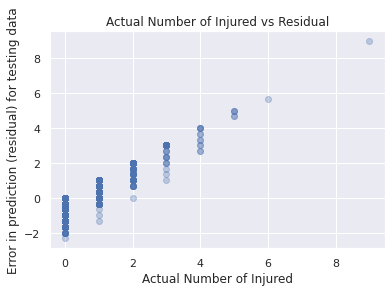

In [31]:
plt.scatter(y_test, y_test - y_test_pred, alpha=0.3)
plt.title("Actual Number of Injured vs Residual")
plt.xlabel("Actual Number of Injured")
plt.ylabel("Error in prediction (residual) for testing data")

To experiment with this overfitting, we can try our model against various k-values to see the resulting MSE values and their differences.

In [32]:
# Predicting via different values of k
# This might take awhile (~25-30m via Google Colab)
knn_train_mse_values = []
knn_test_mse_values = []

for k in [1, 2, 3, 5, 10, 15, 20, 25]:
  # Fit data to KNN model and predict
  print(f'Computing KNN MSE for k = {k}')
  knn_model = KNeighborsRegressor(n_neighbors=k)
  knn_model.fit(x_train, y_train)
  y_train_pred = knn_model.predict(x_train)
  y_test_pred = knn_model.predict(x_test)

  # Calculate the MSEs
  train_mse = mean_squared_error(y_train_pred, y_train)
  test_mse = mean_squared_error(y_test_pred, y_test)
  knn_train_mse_values.append(train_mse)
  knn_test_mse_values.append(test_mse)

Computing KNN MSE for k = 1
Computing KNN MSE for k = 2
Computing KNN MSE for k = 3
Computing KNN MSE for k = 5
Computing KNN MSE for k = 10
Computing KNN MSE for k = 15
Computing KNN MSE for k = 20
Computing KNN MSE for k = 25


In the given k-values we gave to our model, we can see the MSE drops as the k-value increases. As the MSE drops, its value gets closer to our training data's MSE value. At some point, our testing MSE will meet up with the training MSE.

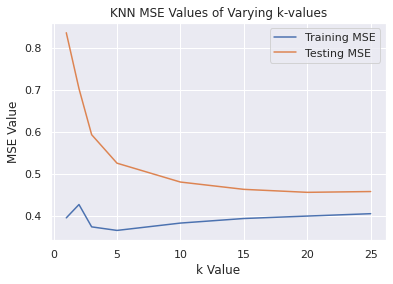

In [40]:
plt.plot([1, 2, 3, 5, 10, 15, 20, 25], knn_train_mse_values)
plt.plot([1, 2, 3, 5, 10, 15, 20, 25], knn_test_mse_values)
plt.xlabel("k Value")
plt.ylabel("MSE Value")
plt.title("KNN MSE Values of Varying k-values")
plt.legend(['Training MSE', 'Testing MSE'])

## Predicting Number of Injured via Decision Trees

Alternatively, we can try predicting with a different model - decision trees.

In [34]:
# We'll be using a default depth of 3 and simply passing the x and y data from earlier
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [35]:
# Now we use the model to predict on our training and testing data to get the MSE values
train_pred = tree.predict(x_train)
test_pred = tree.predict(x_test)

In [36]:
mse_train = mean_squared_error(train_pred, y_train)
mse_test = mean_squared_error(test_pred, y_test)

print(f"MSE Results\nTrain: {mse_train}\nTest: {mse_test}\nDifference: {abs(mse_test - mse_train)}")

MSE Results
Train: 0.40863012925229475
Test: 0.45946413075828313
Difference: 0.05083400150598838


Below, we can see our model's generated decision tree for our data.

[Text(1117.7884615384617, 330.3125, 'CONTRIBUTING FACTOR VEHICLE 3_UNSPECIFIED <= 0.5\nmse = 0.456\nsamples = 7500\nvalue = 0.283'),
 Text(596.1538461538462, 235.9375, 'CONTRIBUTING FACTOR VEHICLE 2_UNSPECIFIED <= 0.5\nmse = 0.37\nsamples = 7115\nvalue = 0.26'),
 Text(298.0769230769231, 141.5625, 'BOROUGH_MANHATTAN <= 0.5\nmse = 0.385\nsamples = 1940\nvalue = 0.4'),
 Text(149.03846153846155, 47.1875, 'mse = 0.438\nsamples = 1316\nvalue = 0.47'),
 Text(447.11538461538464, 47.1875, 'mse = 0.243\nsamples = 624\nvalue = 0.252'),
 Text(894.2307692307693, 141.5625, 'VEHICLE TYPE CODE 2_BICYCLE <= 0.5\nmse = 0.355\nsamples = 5175\nvalue = 0.208'),
 Text(745.1923076923077, 47.1875, 'mse = 0.351\nsamples = 5068\nvalue = 0.195'),
 Text(1043.269230769231, 47.1875, 'mse = 0.146\nsamples = 107\nvalue = 0.822'),
 Text(1639.4230769230771, 235.9375, 'VEHICLE TYPE CODE 2_LARGE COM VEH(6 OR MORE TIRES) <= 0.5\nmse = 1.862\nsamples = 385\nvalue = 0.699'),
 Text(1490.3846153846155, 141.5625, 'VEHICLE TYPE

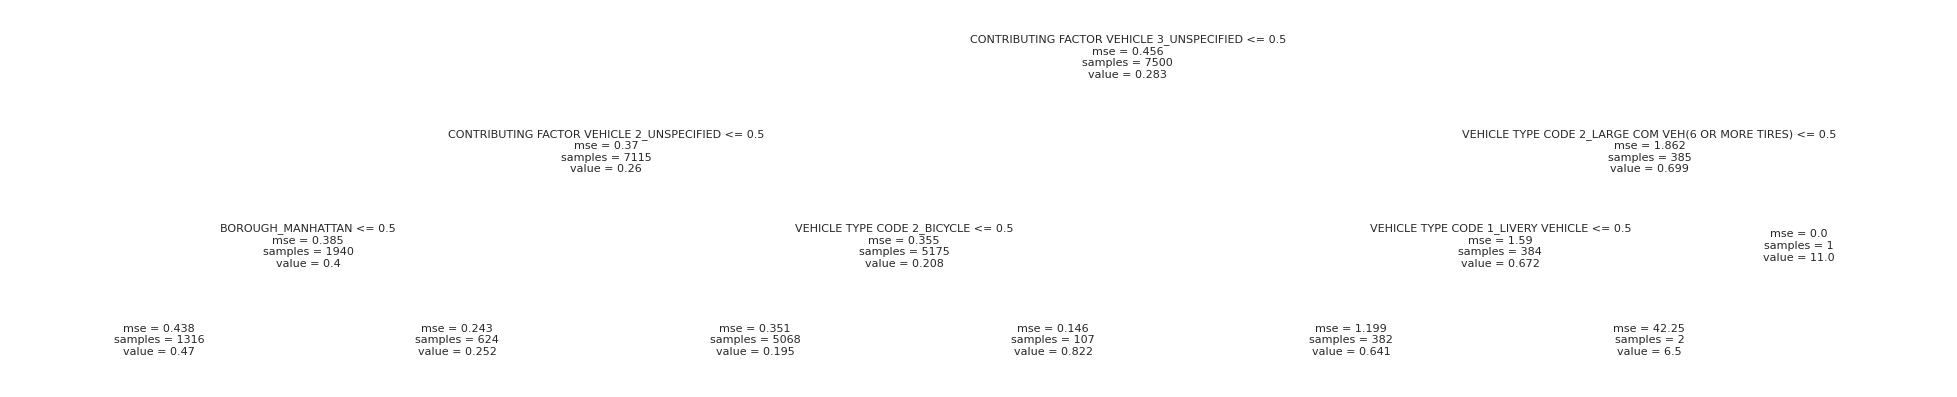

In [37]:
# Show the decision tree
# I'm honestly not sure why the tree isn't displaying the boxes and arrows
# I spent a good amount of time trying to figure it out
plt.figure(figsize=(25, 5), dpi=100)
plot_tree(tree, feature_names=x.columns, fontsize=8)

Using a decision tree, we can see that our model is fitting the data quite nicely although the MSE values are still relatively high. To fix this, we can see what our MSEs can potentially be by using higher or lower max_depths.

In [38]:
# Decision Tree with varying depths
tree_train_mse_values = []
tree_test_mse_values = []

for k in np.arange(1, 11):
  # Fit data to Decision Tree model and predict
  print(f'Computing Decision Tree MSE for k = {k}')
  tree_model = DecisionTreeRegressor(max_depth=k)
  tree_model.fit(x_train, y_train)
  y_train_pred = tree_model.predict(x_train)
  y_test_pred = tree_model.predict(x_test)

  # Calculate the MSEs
  train_mse = mean_squared_error(y_train_pred, y_train)
  test_mse = mean_squared_error(y_test_pred, y_test)
  tree_train_mse_values.append(train_mse)
  tree_test_mse_values.append(test_mse)

Computing Decision Tree MSE for k = 1
Computing Decision Tree MSE for k = 2
Computing Decision Tree MSE for k = 3
Computing Decision Tree MSE for k = 4
Computing Decision Tree MSE for k = 5
Computing Decision Tree MSE for k = 6
Computing Decision Tree MSE for k = 7
Computing Decision Tree MSE for k = 8
Computing Decision Tree MSE for k = 9
Computing Decision Tree MSE for k = 10


After computing MSE values for our decision tree, we plot the values onto a chart to see their differences. Interestingly enough, our MSE values seem to diverge at higher depths.

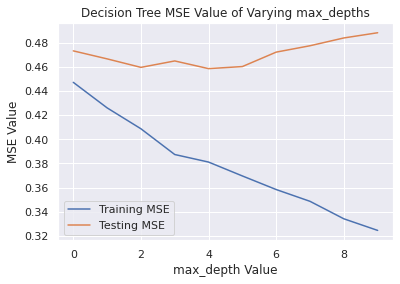

In [39]:
plt.plot(np.arange(10), tree_train_mse_values)
plt.plot(np.arange(10), tree_test_mse_values)
plt.xlabel("max_depth Value")
plt.ylabel("MSE Value")
plt.title("Decision Tree MSE Value of Varying max_depths")
plt.legend(['Training MSE', 'Testing MSE'])

Using a decision tree for our data doesn't seem to be the best option as higher depths will only increase the difference between the MSE values. However, for our KNN model, it does start out with a high difference but eventually the difference in MSE values is reduced as the model uses higher k-values. Using a KNN model and finding the right k-value is the best approach to predicting the number of injured in a given collision.